<a href="https://colab.research.google.com/github/AbdullahEmadeldeen/DeepLearning---Celeb-face-recognition-project/blob/main/Copy_of_facenet_arcface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔍 Problem Definition

This project builds a **face recognition model** using a **FaceNet (InceptionResnetV1)** backbone for embeddings and an **ArcFace** layer for classification.  
The dataset consists of face images organized by identity, and the model learns to generate discriminative embeddings for each class.

We will follow this workflow:
1. Problem Definition and Data Collection  
2. Data Cleaning and Analysis  
3. Feature Engineering  
4. Model Design  
5. Model Training  
6. Model Testing and Inference  
7. GUI Implementation and Application Running

## 1. Install Dependencies

In [ ]:
# !pip install --upgrade torchvision
# !pip install facenet-pytorch

## 2. Imports & Configuration

In [ ]:
# ----- PyTorch -----
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler

# ----- TorchVision -----
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# ----- Pretrained Models -----
from facenet_pytorch import InceptionResnetV1

# ----- Utilities -----
import os
import json
import math
import random
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError

## 📥 Data Collection


Loading dataset from: /content/local_pins_dataset
Total images: 17534
Total classes: 105
Example classes: ['Adriana Lima', 'Alex Lawther', 'Alexandra Daddario', 'Alvaro Morte', 'Amanda Crew']


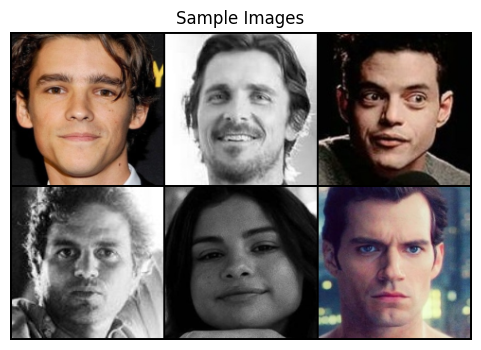

In [ ]:
DATASET_PATH = "/content/local_pins_dataset"
print(f"Loading dataset from: {DATASET_PATH}")

# Load dataset
full_dataset = datasets.ImageFolder(DATASET_PATH)
classes = full_dataset.classes

print(f"Total images: {len(full_dataset)}")
print(f"Total classes: {len(classes)}")
print("Example classes:", classes[:5])

# Display Sample Images
display_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

sample_indices = random.sample(range(len(full_dataset)), k=6)
imgs, labels = [], []

for idx in sample_indices:
    img, lbl = full_dataset[idx]
    img = display_transform(img)
    imgs.append(img)
    labels.append(classes[lbl])

grid = make_grid(imgs, nrow=3, normalize=True, scale_each=True)

plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.title("Sample Images")
plt.axis("off")
plt.show()


## 🧹 Data Cleaning & Analysis

- Load dataset structure (classes & image paths)  
- Check class distribution  
- Identify classes with very few samples  
- Randomly sample images to detect corrupted files  
- Collect basic image size statistics  
- Save a short JSON report for reference

In [ ]:
# Config
DATASET_PATH = DATASET_PATH
SAMPLE_N = 500
MIN_SAMPLES = 10
REPORT_FILE = "data_cleaning_report.json"

# path check
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset path not found: {DATASET_PATH}")

# Load dataset metadata
dataset = datasets.ImageFolder(DATASET_PATH)
samples = dataset.samples
classes = dataset.classes

n_total = len(samples)
print(f"Dataset: {DATASET_PATH}")
print(f"Total images: {n_total}")
print(f"Total classes: {len(classes)}")

# Class distribution
counts = Counter([lbl for _, lbl in samples])
counts_by_class = {classes[i]: counts[i] for i in range(len(classes))}
sorted_counts = sorted(counts_by_class.items(), key=lambda x: x[1], reverse=True)

print("\nTop 5 classes by image count:")
for k, v in sorted_counts[:5]:
    print(f"  {k}: {v}")

# Small class detection
small_classes = [c for c, n in sorted_counts if n < MIN_SAMPLES]
print(f"\nClasses with fewer than {MIN_SAMPLES} images: {len(small_classes)}")
if small_classes:
    print("Example small classes:", small_classes[:10])

# Sample-based corruption & size check (fast)
sample_n = min(SAMPLE_N, n_total)
print(f"\nSampling {sample_n} images for quick validity check...")
sample_indices = random.sample(range(n_total), sample_n)
sample_paths = [samples[i][0] for i in sample_indices]

corrupted = []
sizes = []

for p in sample_paths:
    try:
        with Image.open(p) as im:
            im.verify()
        # reopen to read size
        with Image.open(p) as im:
            sizes.append(im.size)  # (width, height)
    except (UnidentifiedImageError, OSError):
        corrupted.append(p)

print(f"Corrupted images in sample: {len(corrupted)} / {sample_n}")
if corrupted:
    print("Example corrupted files (up to 5):")
    for c in corrupted[:5]:
        print(" ", c)

# Size statistics from sample
size_stats = {}
if sizes:
    widths = np.array([w for w, h in sizes])
    heights = np.array([h for w, h in sizes])
    size_stats = {
        "width_min": int(widths.min()),
        "width_mean": float(widths.mean()),
        "width_max": int(widths.max()),
        "height_min": int(heights.min()),
        "height_mean": float(heights.mean()),
        "height_max": int(heights.max())
    }
    print("\nSample image size stats:")
    print(f" Width -> min: {size_stats['width_min']}, mean: {size_stats['width_mean']:.1f}, max: {size_stats['width_max']}")
    print(f" Height-> min: {size_stats['height_min']}, mean: {size_stats['height_mean']:.1f}, max: {size_stats['height_max']}")

# Save short report
report = {
    "dataset_path": DATASET_PATH,
    "total_images": n_total,
    "total_classes": len(classes),
    "top_10_classes": sorted_counts[:10],
    "num_small_classes_below_min": len(small_classes),
    "small_classes_sample": small_classes[:50],
    "sample_checked": sample_n,
    "corrupted_in_sample": len(corrupted),
    "corrupt_examples": corrupted[:10],
    "sample_image_size_stats": size_stats
}

with open(REPORT_FILE, "w") as fh:
    json.dump(report, fh, indent=2)

print(f"\nReport saved to {REPORT_FILE}")


Dataset: /content/local_pins_dataset
Total images: 17534
Total classes: 105

Top 5 classes by image count:
  Leonardo DiCaprio: 237
  Robert Downey Jr: 233
  Katherine Langford: 226
  Alexandra Daddario: 225
  elizabeth olsen: 221

Classes with fewer than 10 images: 0

Sampling 500 images for quick validity check...
Corrupted images in sample: 0 / 500

Sample image size stats:
 Width -> min: 95, mean: 206.0, max: 564
 Height-> min: 105, mean: 220.3, max: 802

Report saved to data_cleaning_report.json


## Feature Engineering

Defines the runtime transforms for training and validation and prepares DataLoaders.
Transforms are applied on-the-fly (no changes to raw files).  
Key choices: image size, basic augmentations (flip, color jitter), normalization, and a deterministic train/validation split.

In [ ]:
IMAGE_SIZE = 160
BATCH_SIZE = 64
VAL_SPLIT = 0.1
NUM_WORKERS = 4
RANDOM_SEED = 42

# transforms
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# TransformSubset wrapper (avoids shared-dataset transform leakage)
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# dataset / splits
full_dataset = datasets.ImageFolder(DATASET_PATH)
n_total = len(full_dataset)
val_size = int(n_total * VAL_SPLIT)
train_size = n_total - val_size

train_subset, val_subset = random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

# wrap subsets with per-split transforms
train_ds = TransformSubset(train_subset, transform=train_transform)
val_ds   = TransformSubset(val_subset, transform=val_transform)

# dataloaders
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=max(1, NUM_WORKERS//2), pin_memory=True
)

print(f"IMAGE_SIZE={IMAGE_SIZE}, BATCH_SIZE={BATCH_SIZE}, VAL_SPLIT={VAL_SPLIT}")
print(f"Total: {n_total} | Train: {len(train_ds)} | Val: {len(val_ds)}")

IMAGE_SIZE=160, BATCH_SIZE=64, VAL_SPLIT=0.1
Total: 17534 | Train: 15781 | Val: 1753


## Model Design

Defines the model architecture used for training.

What this cell does:
- Implements an **ArcFace margin product** (Additive Angular Margin) head.
- Loads **InceptionResnetV1 (FaceNet)** as the embedding backbone (pretrained).
- Builds `FaceNetArcFace` that returns `(logits, embeddings)` so training uses logits for classification and embeddings for visualization/ downstream use.

In [ ]:
class ArcFaceMarginProduct(nn.Module):
    def __init__(self, embedding_size, n_classes, s=30.0, m=0.5, easy_margin=False):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(n_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)
        self.s = s
        self.m = m
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        self.easy_margin = easy_margin

    def forward(self, embeddings, labels=None):
        W = F.normalize(self.weight, dim=1)
        cos_theta = torch.mm(embeddings, W.t()).clamp(-1.0, 1.0)

        if labels is None:
            return cos_theta * self.s

        cos_y = cos_theta.gather(1, labels.view(-1, 1)).view(-1)
        sin_theta = torch.sqrt(1.0 - cos_y * cos_y).clamp(0.0, 1.0)
        phi = cos_y * self.cos_m - sin_theta * self.sin_m

        if self.easy_margin:
            phi = torch.where(cos_y > 0, phi, cos_y)
        else:
            phi = torch.where(cos_y > self.th, phi, cos_y - self.mm)

        logits = cos_theta.clone()
        logits.scatter_(1, labels.view(-1, 1), phi.view(-1, 1))
        logits = logits * self.s
        return logits


class FaceNetArcFace(nn.Module):
    def __init__(self, n_classes, embedding_size=512, pretrained='vggface2', s=30.0, m=0.5):
        super().__init__()
        self.backbone = InceptionResnetV1(pretrained=pretrained, classify=False)
        self.margin_product = ArcFaceMarginProduct(
            embedding_size=embedding_size,
            n_classes=n_classes,
            s=s,
            m=m
        )

    def forward(self, x, labels=None):
        embeddings = self.backbone(x)
        embeddings = F.normalize(embeddings, dim=1)
        logits = self.margin_product(embeddings, labels)
        return logits, embeddings

## Model Training (functions)

This cell provides the training and validation loop functions used during model training.

What it contains:
- `train_one_epoch`: single-epoch training (mixed-precision compatible).
- `validate_one_epoch`: single-epoch validation.
Both functions are lightweight, use `autocast` + `GradScaler`, clip gradients, and return `(loss, accuracy)`.

In [ ]:
def train_one_epoch(model, train_loader, optimizer, criterion, scaler, scheduler, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch} [TRAIN]", leave=False)
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            logits, _ = model(imgs, labels)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=correct/total)

    return running_loss / total, correct / total


def validate_one_epoch(model, val_loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(val_loader, desc=f"Epoch {epoch} [VAL]", leave=False)
    with torch.no_grad():
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast():
                logits, _ = model(imgs, labels)
                loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=correct/total)

    return running_loss / total, correct / total
  # === Configuration ===

DATASET_PATH = "/content/local_pins_dataset"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 64
IMAGE_SIZE = 160
EMBEDDING_SIZE = 512
NUM_CLASSES = 105
EPOCHS = 25

print("Device:", DEVICE)


Device: cuda:0


## Model Training (Main Execution)

This step initializes all training components and runs the full training loop.

What this cell does:
- Builds the FaceNet + ArcFace model.
- Sets the loss function, optimizer, scheduler, and mixed-precision scaler.
- Trains the model for the defined number of epochs using the training/validation functions.
- Tracks loss and accuracy across epochs.
- Saves the best model based on validation accuracy.
- Plots training and validation curves at the end.

Starting training...


Epoch 1 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 1 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1/25: Train loss=17.0393, acc=0.0000 | Val loss=14.0793, acc=0.0000


Epoch 2 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 2 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2/25: Train loss=11.6285, acc=0.0015 | Val loss=9.0879, acc=0.0148
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.0148)


Epoch 3 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 3 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3/25: Train loss=7.0302, acc=0.0820 | Val loss=5.0119, acc=0.2339
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.2339)


Epoch 4 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 4 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4/25: Train loss=3.6444, acc=0.3692 | Val loss=2.6328, acc=0.5425
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.5425)


Epoch 5 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 5 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5/25: Train loss=1.7854, acc=0.6401 | Val loss=1.5882, acc=0.7102
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.7102)


Epoch 6 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 6 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6/25: Train loss=0.9133, acc=0.8049 | Val loss=1.1250, acc=0.7901
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.7901)


Epoch 7 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 7 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7/25: Train loss=0.5001, acc=0.8885 | Val loss=0.9102, acc=0.8323
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.8323)


Epoch 8 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 8 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8/25: Train loss=0.2686, acc=0.9405 | Val loss=0.8298, acc=0.8523
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.8523)


Epoch 9 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 9 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9/25: Train loss=0.1595, acc=0.9649 | Val loss=0.7241, acc=0.8745
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.8745)


Epoch 10 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 10 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10/25: Train loss=0.0901, acc=0.9816 | Val loss=0.6752, acc=0.8831
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.8831)


Epoch 11 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 11 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 11/25: Train loss=0.0523, acc=0.9906 | Val loss=0.6624, acc=0.8916
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.8916)


Epoch 12 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 12 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 12/25: Train loss=0.0359, acc=0.9939 | Val loss=0.6123, acc=0.8990
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.8990)


Epoch 13 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 13 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 13/25: Train loss=0.0254, acc=0.9963 | Val loss=0.5769, acc=0.9025
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.9025)


Epoch 14 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 14 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 14/25: Train loss=0.0185, acc=0.9977 | Val loss=0.5692, acc=0.9070
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.9070)


Epoch 15 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 15 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 15/25: Train loss=0.0137, acc=0.9986 | Val loss=0.5447, acc=0.9133
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.9133)


Epoch 16 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 16 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 16/25: Train loss=0.0106, acc=0.9985 | Val loss=0.5315, acc=0.9150
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.9150)


Epoch 17 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 17 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 17/25: Train loss=0.0076, acc=0.9994 | Val loss=0.5227, acc=0.9156
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.9156)


Epoch 18 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 18 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 18/25: Train loss=0.0065, acc=0.9996 | Val loss=0.5127, acc=0.9144


Epoch 19 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 19 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 19/25: Train loss=0.0056, acc=0.9998 | Val loss=0.5118, acc=0.9156


Epoch 20 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 20 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 20/25: Train loss=0.0048, acc=0.9998 | Val loss=0.4985, acc=0.9173
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.9173)


Epoch 21 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 21 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 21/25: Train loss=0.0047, acc=0.9997 | Val loss=0.5096, acc=0.9184
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.9184)


Epoch 22 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 22 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 22/25: Train loss=0.0044, acc=0.9997 | Val loss=0.4919, acc=0.9196
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.9196)


Epoch 23 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 23 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 23/25: Train loss=0.0040, acc=0.9998 | Val loss=0.5017, acc=0.9184


Epoch 24 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 24 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 24/25: Train loss=0.0036, acc=0.9998 | Val loss=0.4998, acc=0.9224
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.9224)


Epoch 25 [TRAIN]:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch 25 [VAL]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 25/25: Train loss=0.0038, acc=0.9997 | Val loss=0.4899, acc=0.9230
  🔥 New best model saved: best_facenet_arcface.pth (val_acc=0.9230)


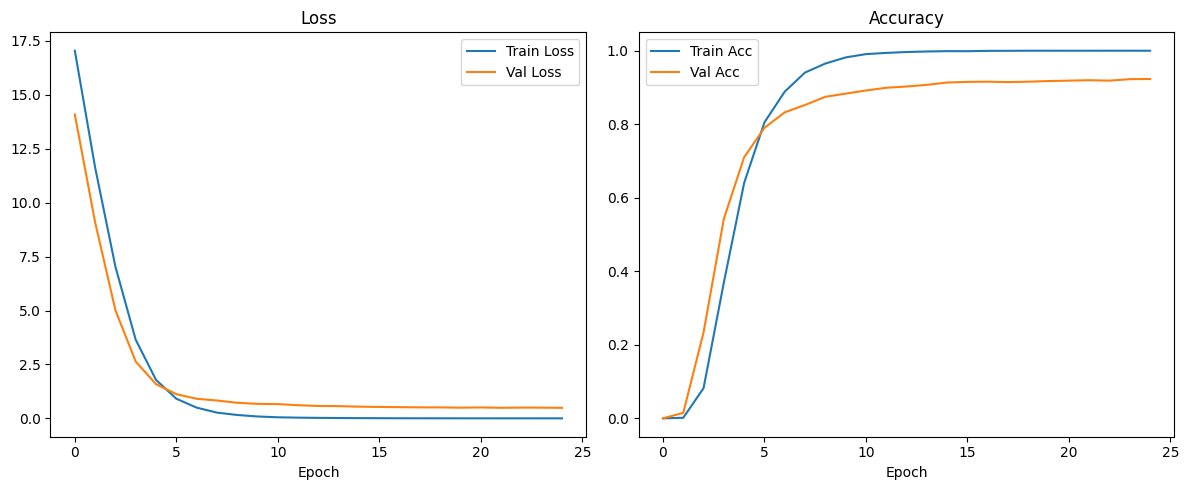

In [ ]:
# Config (these variables should already be defined in the notebook; adjust if needed)
MODEL_SAVE_PATH = "best_facenet_arcface.pth"
DEVICE = DEVICE
EPOCHS = EPOCHS
NUM_CLASSES = NUM_CLASSES
EMBEDDING_SIZE = EMBEDDING_SIZE

# Initialize model
model = FaceNetArcFace(
    n_classes=NUM_CLASSES,
    embedding_size=EMBEDDING_SIZE,
    pretrained='vggface2',
    s=30.0,
    m=0.5
).to(DEVICE)

# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer: lower LR for pretrained backbone, higher LR for ArcFace head
optimizer = torch.optim.SGD([
    {'params': model.backbone.parameters(), 'lr': 0.001},
    {'params': model.margin_product.parameters(), 'lr': 0.01}
], momentum=0.9, weight_decay=5e-4)

# Scheduler: OneCycleLR (step per batch). Provide steps_per_epoch = len(train_loader)
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[0.001, 0.01],
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.2,
    div_factor=10.0,
    final_div_factor=100.0
)

# Mixed precision scaler
scaler = GradScaler()

# Training loop
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting training...")
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, scaler, scheduler, DEVICE, epoch
    )
    val_loss, val_acc = validate_one_epoch(
        model, val_loader, criterion, DEVICE, epoch
    )

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS}: Train loss={train_loss:.4f}, acc={train_acc:.4f} | Val loss={val_loss:.4f}, acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"  🔥 New best model saved: {MODEL_SAVE_PATH} (val_acc={best_val_acc:.4f})")

# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel("Epoch")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from IPython.display import FileLink, display

# The path should be relative to the notebook's working directory
display(FileLink(, result_html_prefix="Click here to download: "))
